In [22]:
xfile = 'F:\workspace\j6stock\XOpenHighLowCloseVol_tp10_cl10.txt'
lstm_size = 120         # 3 times the amount of channels
lstm_layers = 2        # Number of layers
batch_size = 2048       # Batch size
learning_rate = 0.001  #0.0001  # Learning rate (default is 0.001)
epochs = 200

# Fixed
#amount_of_features_cvs = 5 # cvs with prefix with feature column
#n_channels = amount_of_features
seq_len = lstm_size
y_column = 6

In [23]:
import tensorflow as tf
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
from keras import backend as K

In [24]:
def get_stock_data(normalize=True, ma=[]):
    """
    Return a dataframe of that stock and normalize all the values. 
    (Optional: create moving average)
    """
    df = pd.read_csv(filepath_or_buffer  = xfile )

    df['change'] = df['open'] - df['close']
    df.dropna(inplace=True)
    
    # Moving Average    
    if ma != []:
        for moving in ma:
            df['{}ma'.format(moving)] = df['close'].rolling(window=moving).mean()
    df.dropna(inplace=True)
    if normalize:
        min_max_scaler = preprocessing.MinMaxScaler()
        df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
        df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
        df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
        #df['vol'] = min_max_scaler.fit_transform(df.vol.values.reshape(-1,1))
        df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
        df['change'] = min_max_scaler.fit_transform(df['change'].values.reshape(-1,1))
        if ma != []:
            for moving in ma:
                df['{}ma'.format(moving)] = min_max_scaler.fit_transform(df['{}ma'.format(moving)].values.reshape(-1,1))  
    df.dropna(inplace=True)
               
    # Move y_result to the rightmost for the ease of training
    adj_close = df['y_result']
    df.drop(labels=['y_result'], axis=1, inplace=True)
    df = pd.concat([df, adj_close], axis=1)
      
    return df

In [25]:
df = get_stock_data( ma=[50, 100, 200])
amount_of_features = len(df.columns)-1

In [26]:
def plot_stock(df):
    print(df.head())
    plt.subplot(211)
    plt.plot(df['close'], color='red', label='Close')
    plt.legend(loc='best')
    plt.subplot(212)
    plt.plot(df['change'], color='blue', label='Percentage change')
    plt.legend(loc='best')
    plt.show()

         open      high       low     close    change      50ma     100ma  \
199  0.358586  0.355870  0.358374  0.357085  0.410872  0.351429  0.351070   
200  0.357245  0.354622  0.357608  0.356606  0.399494  0.351433  0.351063   
201  0.356623  0.354862  0.357799  0.356893  0.387484  0.351445  0.351060   
202  0.357054  0.354478  0.358422  0.357133  0.390013  0.351502  0.351082   
203  0.357293  0.355774  0.358709  0.358138  0.379899  0.351587  0.351141   

        200ma  y_result  
199  0.346428         0  
200  0.346426         0  
201  0.346424         0  
202  0.346433         0  
203  0.346448         0  


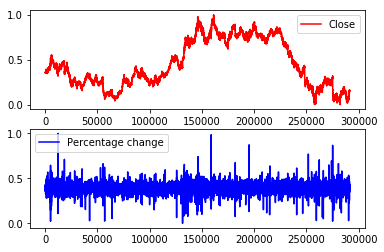

In [27]:
plot_stock(df)

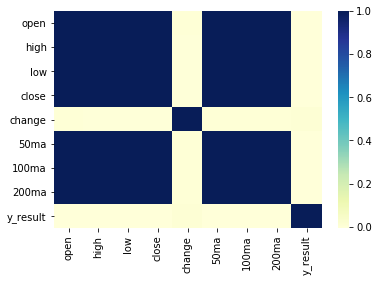

In [28]:
corr = df.corr()
ax = sns.heatmap(corr, cmap="YlGnBu")
plt.show()

In [29]:
def load_data(stock, seq_len):
    print ("Amount of features = {}".format(amount_of_features))
    data = stock.as_matrix()
    sequence_length = seq_len + 1 # index starting from 0
    x_result = []
    y_result = []
    for index in range(seq_len, len(data) ): # maxmimum date = lastest date - sequence length
        x_result.append(data[index-seq_len: index,:-1]) # index : index + 22days
        y_result.append(data[index ,amount_of_features]);

    #print('---', data[0])
    #print('---', x_result[0])
    #print('---', y_result[0])
    x_result = np.array(x_result)
    y_result = np.array(y_result)
    row = round(0.6 * y_result.shape[0]) # 80% split
    print ("Amount of training data = {}".format(0.9 * x_result.shape[0]))
    print ("Amount of testing data = {}".format(0.1 * y_result.shape[0]))
     
    X_train = x_result[:int(row), :] # 90% date
    y_train = y_result[:int(row)] # 90% date
        

    X_test = x_result[int(row):, :]
    y_test = y_result[int(row):]
    # filter for 1 and -1 for validation only
    X_test = X_test[y_test[:]!=0,:]
    y_test = y_test[y_test[:]!=0]
    #print(result.shape[0], len(y_result), int(row), y_result[int(row):])
    #X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features-1))
    #X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features-1))
    
    return [X_train, y_train, X_test, y_test]

In [30]:
lb = preprocessing.LabelBinarizer()
lb.fit([1, 0, -1])

X_tr, lab_tr, X_vld, lab_vld = load_data(df, seq_len)
y_tr = lb.transform(lab_tr)
y_vld = lb.transform(lab_vld)
print(X_tr.shape, lab_tr.shape, X_vld.shape, lab_vld.shape)
print(amount_of_features)

Amount of features = 8
Amount of training data = 261918.9
Amount of testing data = 29102.100000000002
(174613, 120, 8) (174613,) (70626, 120, 8) (70626,)
8


In [31]:
def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [32]:
graph = tf.Graph()
n_channels = amount_of_features
n_classes = lb.transform([1]).shape[1]
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [33]:
with graph.as_default():
    # Construct the LSTM inputs and LSTM cells
    lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
    lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
    
    # To cells
    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?
    
    # Open up the tensor into a list of seq_len pieces
    lstm_in = tf.split(lstm_in, seq_len, 0)
    
    # Add LSTM layers
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    initial_state = cell.zero_state(batch_size, tf.float32)

Define forward pass, cost function and optimizer:

In [34]:
with graph.as_default():
    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                     initial_state = initial_state)
    
    # We only need the last output tensor to pass into a classifier
    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    #optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost) # No grad clipping
    
    # Grad clipping
    train_op = tf.train.AdamOptimizer(learning_rate_)

    gradients = train_op.compute_gradients(cost)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]
    optimizer = train_op.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [35]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [36]:
interation_compute_val = 1
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, 
                    initial_state : state, learning_rate_ : learning_rate}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 25 iterations
            if (iteration%interation_compute_val == 50):
                
                # Initiate for validation set
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                
                val_acc_ = []
                val_loss_ = []
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0, initial_state : val_state}
                    
                    # Loss
                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)
                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/200 Iteration: 5 Train loss: 1.089436 Train acc: 0.352539
Epoch: 0/200 Iteration: 10 Train loss: 1.105273 Train acc: 0.260254
Epoch: 0/200 Iteration: 15 Train loss: 1.096695 Train acc: 0.348145
Epoch: 0/200 Iteration: 20 Train loss: 1.090095 Train acc: 0.410645
Epoch: 0/200 Iteration: 25 Train loss: 1.141691 Train acc: 0.312988
Epoch: 0/200 Iteration: 30 Train loss: 1.062420 Train acc: 0.467773
Epoch: 0/200 Iteration: 35 Train loss: 0.995617 Train acc: 0.579102
Epoch: 0/200 Iteration: 40 Train loss: 0.985014 Train acc: 0.584961
Epoch: 0/200 Iteration: 45 Train loss: 1.136933 Train acc: 0.278320
Epoch: 0/200 Iteration: 50 Train loss: 1.043005 Train acc: 0.631836
Epoch: 0/200 Iteration: 55 Train loss: 1.064301 Train acc: 0.494629
Epoch: 0/200 Iteration: 60 Train loss: 1.096161 Train acc: 0.400879
Epoch: 0/200 Iteration: 65 Train loss: 1.259961 Train acc: 0.204590
Epoch: 0/200 Iteration: 70 Train loss: 1.108186 Train acc: 0.281250
Epoch: 0/200 Iteration: 75 Train loss: 1.044770 T

Epoch: 7/200 Iteration: 605 Train loss: 1.094045 Train acc: 0.406738
Epoch: 7/200 Iteration: 610 Train loss: 1.140905 Train acc: 0.348633
Epoch: 7/200 Iteration: 615 Train loss: 1.095391 Train acc: 0.410156
Epoch: 7/200 Iteration: 620 Train loss: 1.137013 Train acc: 0.312988
Epoch: 7/200 Iteration: 625 Train loss: 1.064102 Train acc: 0.467773
Epoch: 7/200 Iteration: 630 Train loss: 1.000078 Train acc: 0.579102
Epoch: 7/200 Iteration: 635 Train loss: 1.007759 Train acc: 0.584961
Epoch: 7/200 Iteration: 640 Train loss: 1.112316 Train acc: 0.278320
Epoch: 7/200 Iteration: 645 Train loss: 0.988617 Train acc: 0.631836
Epoch: 7/200 Iteration: 650 Train loss: 1.062258 Train acc: 0.494629
Epoch: 7/200 Iteration: 655 Train loss: 1.092666 Train acc: 0.400391
Epoch: 7/200 Iteration: 660 Train loss: 1.137960 Train acc: 0.204590
Epoch: 7/200 Iteration: 665 Train loss: 1.099841 Train acc: 0.312988
Epoch: 7/200 Iteration: 670 Train loss: 1.035450 Train acc: 0.465332
Epoch: 7/200 Iteration: 675 Train 

Epoch: 14/200 Iteration: 1195 Train loss: 1.056727 Train acc: 0.503418
Epoch: 14/200 Iteration: 1200 Train loss: 1.090792 Train acc: 0.399902
Epoch: 14/200 Iteration: 1205 Train loss: 1.143493 Train acc: 0.348633
Epoch: 14/200 Iteration: 1210 Train loss: 1.095486 Train acc: 0.410156
Epoch: 14/200 Iteration: 1215 Train loss: 1.141695 Train acc: 0.312988
Epoch: 14/200 Iteration: 1220 Train loss: 1.060116 Train acc: 0.467773
Epoch: 14/200 Iteration: 1225 Train loss: 0.999934 Train acc: 0.579102
Epoch: 14/200 Iteration: 1230 Train loss: 1.000967 Train acc: 0.584961
Epoch: 14/200 Iteration: 1235 Train loss: 1.113355 Train acc: 0.278320
Epoch: 14/200 Iteration: 1240 Train loss: 0.980844 Train acc: 0.631836
Epoch: 14/200 Iteration: 1245 Train loss: 1.065757 Train acc: 0.494629
Epoch: 14/200 Iteration: 1250 Train loss: 1.112788 Train acc: 0.290039
Epoch: 14/200 Iteration: 1255 Train loss: 1.099602 Train acc: 0.346680
Epoch: 14/200 Iteration: 1260 Train loss: 1.096134 Train acc: 0.352051
Epoch:

Epoch: 20/200 Iteration: 1775 Train loss: 1.026903 Train acc: 0.416504
Epoch: 20/200 Iteration: 1780 Train loss: 1.175847 Train acc: 0.327637
Epoch: 20/200 Iteration: 1785 Train loss: 1.194475 Train acc: 0.242676
Epoch: 21/200 Iteration: 1790 Train loss: 1.055983 Train acc: 0.503418
Epoch: 21/200 Iteration: 1795 Train loss: 1.092070 Train acc: 0.399902
Epoch: 21/200 Iteration: 1800 Train loss: 1.141630 Train acc: 0.348633
Epoch: 21/200 Iteration: 1805 Train loss: 1.092843 Train acc: 0.410156
Epoch: 21/200 Iteration: 1810 Train loss: 1.142909 Train acc: 0.312988
Epoch: 21/200 Iteration: 1815 Train loss: 1.059895 Train acc: 0.467773
Epoch: 21/200 Iteration: 1820 Train loss: 1.000083 Train acc: 0.579102
Epoch: 21/200 Iteration: 1825 Train loss: 1.001472 Train acc: 0.584961
Epoch: 21/200 Iteration: 1830 Train loss: 1.119508 Train acc: 0.278320
Epoch: 21/200 Iteration: 1835 Train loss: 0.981665 Train acc: 0.631836
Epoch: 21/200 Iteration: 1840 Train loss: 1.061840 Train acc: 0.494629
Epoch:

Epoch: 27/200 Iteration: 2355 Train loss: 1.107515 Train acc: 0.269043
Epoch: 27/200 Iteration: 2360 Train loss: 1.096212 Train acc: 0.393555
Epoch: 27/200 Iteration: 2365 Train loss: 1.096061 Train acc: 0.403320
Epoch: 27/200 Iteration: 2370 Train loss: 1.013983 Train acc: 0.449707
Epoch: 27/200 Iteration: 2375 Train loss: 1.188657 Train acc: 0.328125
Epoch: 27/200 Iteration: 2380 Train loss: 1.197102 Train acc: 0.231445
Epoch: 28/200 Iteration: 2385 Train loss: 1.057811 Train acc: 0.503418
Epoch: 28/200 Iteration: 2390 Train loss: 1.093196 Train acc: 0.399902
Epoch: 28/200 Iteration: 2395 Train loss: 1.140304 Train acc: 0.348633
Epoch: 28/200 Iteration: 2400 Train loss: 1.093290 Train acc: 0.410156
Epoch: 28/200 Iteration: 2405 Train loss: 1.142109 Train acc: 0.312988
Epoch: 28/200 Iteration: 2410 Train loss: 1.060399 Train acc: 0.467773
Epoch: 28/200 Iteration: 2415 Train loss: 1.001072 Train acc: 0.579102
Epoch: 28/200 Iteration: 2420 Train loss: 0.998836 Train acc: 0.584961
Epoch:

Epoch: 34/200 Iteration: 2935 Train loss: 1.126922 Train acc: 0.278320
Epoch: 34/200 Iteration: 2940 Train loss: 0.981504 Train acc: 0.631836
Epoch: 34/200 Iteration: 2945 Train loss: 1.059098 Train acc: 0.494629
Epoch: 34/200 Iteration: 2950 Train loss: 1.120178 Train acc: 0.243164
Epoch: 34/200 Iteration: 2955 Train loss: 1.089803 Train acc: 0.436523
Epoch: 34/200 Iteration: 2960 Train loss: 1.091985 Train acc: 0.449707
Epoch: 34/200 Iteration: 2965 Train loss: 1.019684 Train acc: 0.437500
Epoch: 34/200 Iteration: 2970 Train loss: 1.179105 Train acc: 0.338379
Epoch: 34/200 Iteration: 2975 Train loss: 1.193067 Train acc: 0.232422
Epoch: 35/200 Iteration: 2980 Train loss: 1.053346 Train acc: 0.503418
Epoch: 35/200 Iteration: 2985 Train loss: 1.093601 Train acc: 0.399902
Epoch: 35/200 Iteration: 2990 Train loss: 1.134374 Train acc: 0.348633
Epoch: 35/200 Iteration: 2995 Train loss: 1.090590 Train acc: 0.410156
Epoch: 35/200 Iteration: 3000 Train loss: 1.144647 Train acc: 0.312988
Epoch:

Epoch: 41/200 Iteration: 3515 Train loss: 1.059749 Train acc: 0.467773
Epoch: 41/200 Iteration: 3520 Train loss: 1.000605 Train acc: 0.579102
Epoch: 41/200 Iteration: 3525 Train loss: 0.999318 Train acc: 0.584961
Epoch: 41/200 Iteration: 3530 Train loss: 1.130707 Train acc: 0.278320
Epoch: 41/200 Iteration: 3535 Train loss: 0.977143 Train acc: 0.631836
Epoch: 41/200 Iteration: 3540 Train loss: 1.056601 Train acc: 0.494629
Epoch: 41/200 Iteration: 3545 Train loss: 1.112960 Train acc: 0.251953
Epoch: 41/200 Iteration: 3550 Train loss: 1.088916 Train acc: 0.430664
Epoch: 41/200 Iteration: 3555 Train loss: 1.094062 Train acc: 0.445312
Epoch: 41/200 Iteration: 3560 Train loss: 1.015064 Train acc: 0.442871
Epoch: 41/200 Iteration: 3565 Train loss: 1.187382 Train acc: 0.333496
Epoch: 41/200 Iteration: 3570 Train loss: 1.197835 Train acc: 0.232910
Epoch: 42/200 Iteration: 3575 Train loss: 1.054910 Train acc: 0.503418
Epoch: 42/200 Iteration: 3580 Train loss: 1.093367 Train acc: 0.399902
Epoch:

Epoch: 48/200 Iteration: 4095 Train loss: 1.134172 Train acc: 0.348633
Epoch: 48/200 Iteration: 4100 Train loss: 1.091221 Train acc: 0.410156
Epoch: 48/200 Iteration: 4105 Train loss: 1.144904 Train acc: 0.312988
Epoch: 48/200 Iteration: 4110 Train loss: 1.059339 Train acc: 0.467773
Epoch: 48/200 Iteration: 4115 Train loss: 1.000687 Train acc: 0.579102
Epoch: 48/200 Iteration: 4120 Train loss: 0.997049 Train acc: 0.584961
Epoch: 48/200 Iteration: 4125 Train loss: 1.130394 Train acc: 0.278320
Epoch: 48/200 Iteration: 4130 Train loss: 0.976959 Train acc: 0.631836
Epoch: 48/200 Iteration: 4135 Train loss: 1.057068 Train acc: 0.494629
Epoch: 48/200 Iteration: 4140 Train loss: 1.109236 Train acc: 0.265137
Epoch: 48/200 Iteration: 4145 Train loss: 1.092369 Train acc: 0.410156
Epoch: 48/200 Iteration: 4150 Train loss: 1.094557 Train acc: 0.432617
Epoch: 48/200 Iteration: 4155 Train loss: 1.015387 Train acc: 0.446777
Epoch: 48/200 Iteration: 4160 Train loss: 1.183311 Train acc: 0.327148
Epoch:

Epoch: 54/200 Iteration: 4675 Train loss: 1.190659 Train acc: 0.231445
Epoch: 55/200 Iteration: 4680 Train loss: 1.049124 Train acc: 0.503418
Epoch: 55/200 Iteration: 4685 Train loss: 1.092875 Train acc: 0.399902
Epoch: 55/200 Iteration: 4690 Train loss: 1.136303 Train acc: 0.348633
Epoch: 55/200 Iteration: 4695 Train loss: 1.089844 Train acc: 0.410156
Epoch: 55/200 Iteration: 4700 Train loss: 1.141769 Train acc: 0.312988
Epoch: 55/200 Iteration: 4705 Train loss: 1.059109 Train acc: 0.467773
Epoch: 55/200 Iteration: 4710 Train loss: 1.000541 Train acc: 0.579102
Epoch: 55/200 Iteration: 4715 Train loss: 0.998625 Train acc: 0.584961
Epoch: 55/200 Iteration: 4720 Train loss: 1.136660 Train acc: 0.278320
Epoch: 55/200 Iteration: 4725 Train loss: 0.976650 Train acc: 0.631836
Epoch: 55/200 Iteration: 4730 Train loss: 1.054318 Train acc: 0.494629
Epoch: 55/200 Iteration: 4735 Train loss: 1.101485 Train acc: 0.310547
Epoch: 55/200 Iteration: 4740 Train loss: 1.104420 Train acc: 0.367676
Epoch:

Epoch: 61/200 Iteration: 5255 Train loss: 1.094931 Train acc: 0.450684
Epoch: 61/200 Iteration: 5260 Train loss: 1.013103 Train acc: 0.439941
Epoch: 61/200 Iteration: 5265 Train loss: 1.186412 Train acc: 0.342285
Epoch: 61/200 Iteration: 5270 Train loss: 1.207744 Train acc: 0.231445
Epoch: 62/200 Iteration: 5275 Train loss: 1.057160 Train acc: 0.503418
Epoch: 62/200 Iteration: 5280 Train loss: 1.093801 Train acc: 0.399902
Epoch: 62/200 Iteration: 5285 Train loss: 1.136417 Train acc: 0.348633
Epoch: 62/200 Iteration: 5290 Train loss: 1.092833 Train acc: 0.410156
Epoch: 62/200 Iteration: 5295 Train loss: 1.147172 Train acc: 0.312988
Epoch: 62/200 Iteration: 5300 Train loss: 1.059153 Train acc: 0.467773
Epoch: 62/200 Iteration: 5305 Train loss: 0.998522 Train acc: 0.579102
Epoch: 62/200 Iteration: 5310 Train loss: 0.997751 Train acc: 0.584961
Epoch: 62/200 Iteration: 5315 Train loss: 1.131663 Train acc: 0.278320
Epoch: 62/200 Iteration: 5320 Train loss: 0.978006 Train acc: 0.631836
Epoch:

Epoch: 68/200 Iteration: 5835 Train loss: 1.053609 Train acc: 0.494629
Epoch: 68/200 Iteration: 5840 Train loss: 1.096920 Train acc: 0.353027
Epoch: 68/200 Iteration: 5845 Train loss: 1.095365 Train acc: 0.412598
Epoch: 68/200 Iteration: 5850 Train loss: 1.096771 Train acc: 0.459473
Epoch: 68/200 Iteration: 5855 Train loss: 1.008097 Train acc: 0.449707
Epoch: 68/200 Iteration: 5860 Train loss: 1.190462 Train acc: 0.335938
Epoch: 68/200 Iteration: 5865 Train loss: 1.208320 Train acc: 0.233398
Epoch: 69/200 Iteration: 5870 Train loss: 1.061309 Train acc: 0.503418
Epoch: 69/200 Iteration: 5875 Train loss: 1.092623 Train acc: 0.400391
Epoch: 69/200 Iteration: 5880 Train loss: 1.137471 Train acc: 0.348633
Epoch: 69/200 Iteration: 5885 Train loss: 1.094589 Train acc: 0.410156
Epoch: 69/200 Iteration: 5890 Train loss: 1.148555 Train acc: 0.312988
Epoch: 69/200 Iteration: 5895 Train loss: 1.060305 Train acc: 0.467773
Epoch: 69/200 Iteration: 5900 Train loss: 0.998042 Train acc: 0.579102
Epoch:

Epoch: 75/200 Iteration: 6415 Train loss: 0.996717 Train acc: 0.584961
Epoch: 75/200 Iteration: 6420 Train loss: 1.128505 Train acc: 0.278320
Epoch: 75/200 Iteration: 6425 Train loss: 0.977673 Train acc: 0.631836
Epoch: 75/200 Iteration: 6430 Train loss: 1.057540 Train acc: 0.494629
Epoch: 75/200 Iteration: 6435 Train loss: 1.132098 Train acc: 0.250000
Epoch: 75/200 Iteration: 6440 Train loss: 1.069657 Train acc: 0.471191
Epoch: 75/200 Iteration: 6445 Train loss: 1.087151 Train acc: 0.475586
Epoch: 75/200 Iteration: 6450 Train loss: 1.022968 Train acc: 0.411133
Epoch: 75/200 Iteration: 6455 Train loss: 1.167232 Train acc: 0.321289
Epoch: 75/200 Iteration: 6460 Train loss: 1.182002 Train acc: 0.232422
Epoch: 76/200 Iteration: 6465 Train loss: 1.049841 Train acc: 0.503418
Epoch: 76/200 Iteration: 6470 Train loss: 1.092521 Train acc: 0.399902
Epoch: 76/200 Iteration: 6475 Train loss: 1.133791 Train acc: 0.348633
Epoch: 76/200 Iteration: 6480 Train loss: 1.089398 Train acc: 0.410156
Epoch:

Epoch: 82/200 Iteration: 6995 Train loss: 1.145822 Train acc: 0.312988
Epoch: 82/200 Iteration: 7000 Train loss: 1.060097 Train acc: 0.467773
Epoch: 82/200 Iteration: 7005 Train loss: 1.000972 Train acc: 0.579102
Epoch: 82/200 Iteration: 7010 Train loss: 0.999332 Train acc: 0.584961
Epoch: 82/200 Iteration: 7015 Train loss: 1.137675 Train acc: 0.278320
Epoch: 82/200 Iteration: 7020 Train loss: 0.978275 Train acc: 0.631836
Epoch: 82/200 Iteration: 7025 Train loss: 1.052386 Train acc: 0.494629
Epoch: 82/200 Iteration: 7030 Train loss: 1.091069 Train acc: 0.407227
Epoch: 82/200 Iteration: 7035 Train loss: 1.115640 Train acc: 0.263672
Epoch: 82/200 Iteration: 7040 Train loss: 1.098822 Train acc: 0.432129
Epoch: 82/200 Iteration: 7045 Train loss: 1.004742 Train acc: 0.479492
Epoch: 82/200 Iteration: 7050 Train loss: 1.189731 Train acc: 0.351074
Epoch: 82/200 Iteration: 7055 Train loss: 1.214688 Train acc: 0.240723
Epoch: 83/200 Iteration: 7060 Train loss: 1.069615 Train acc: 0.502441
Epoch:

Epoch: 89/200 Iteration: 7575 Train loss: 1.093423 Train acc: 0.400391
Epoch: 89/200 Iteration: 7580 Train loss: 1.138151 Train acc: 0.348633
Epoch: 89/200 Iteration: 7585 Train loss: 1.094204 Train acc: 0.410156
Epoch: 89/200 Iteration: 7590 Train loss: 1.145625 Train acc: 0.312988
Epoch: 89/200 Iteration: 7595 Train loss: 1.058390 Train acc: 0.467773
Epoch: 89/200 Iteration: 7600 Train loss: 0.999509 Train acc: 0.579102
Epoch: 89/200 Iteration: 7605 Train loss: 0.996934 Train acc: 0.584961
Epoch: 89/200 Iteration: 7610 Train loss: 1.128950 Train acc: 0.278320
Epoch: 89/200 Iteration: 7615 Train loss: 0.976489 Train acc: 0.631836
Epoch: 89/200 Iteration: 7620 Train loss: 1.057931 Train acc: 0.494629
Epoch: 89/200 Iteration: 7625 Train loss: 1.136552 Train acc: 0.249512
Epoch: 89/200 Iteration: 7630 Train loss: 1.070194 Train acc: 0.465332
Epoch: 89/200 Iteration: 7635 Train loss: 1.088458 Train acc: 0.476074
Epoch: 89/200 Iteration: 7640 Train loss: 1.021191 Train acc: 0.411133
Epoch:

Epoch: 95/200 Iteration: 8155 Train loss: 1.168108 Train acc: 0.319824
Epoch: 95/200 Iteration: 8160 Train loss: 1.180489 Train acc: 0.232910
Epoch: 96/200 Iteration: 8165 Train loss: 1.048934 Train acc: 0.503418
Epoch: 96/200 Iteration: 8170 Train loss: 1.092334 Train acc: 0.399902
Epoch: 96/200 Iteration: 8175 Train loss: 1.133132 Train acc: 0.348633
Epoch: 96/200 Iteration: 8180 Train loss: 1.089090 Train acc: 0.410156
Epoch: 96/200 Iteration: 8185 Train loss: 1.146079 Train acc: 0.312988
Epoch: 96/200 Iteration: 8190 Train loss: 1.059616 Train acc: 0.467773
Epoch: 96/200 Iteration: 8195 Train loss: 1.000423 Train acc: 0.579102
Epoch: 96/200 Iteration: 8200 Train loss: 0.998471 Train acc: 0.584961
Epoch: 96/200 Iteration: 8205 Train loss: 1.138104 Train acc: 0.278320
Epoch: 96/200 Iteration: 8210 Train loss: 0.977647 Train acc: 0.631836
Epoch: 96/200 Iteration: 8215 Train loss: 1.052620 Train acc: 0.494629
Epoch: 96/200 Iteration: 8220 Train loss: 1.093828 Train acc: 0.403320
Epoch:

Epoch: 102/200 Iteration: 8730 Train loss: 1.090427 Train acc: 0.402832
Epoch: 102/200 Iteration: 8735 Train loss: 1.109934 Train acc: 0.302246
Epoch: 102/200 Iteration: 8740 Train loss: 1.100779 Train acc: 0.431152
Epoch: 102/200 Iteration: 8745 Train loss: 1.005678 Train acc: 0.460938
Epoch: 102/200 Iteration: 8750 Train loss: 1.188576 Train acc: 0.341797
Epoch: 102/200 Iteration: 8755 Train loss: 1.215942 Train acc: 0.234375
Epoch: 103/200 Iteration: 8760 Train loss: 1.064232 Train acc: 0.503418
Epoch: 103/200 Iteration: 8765 Train loss: 1.094014 Train acc: 0.400391
Epoch: 103/200 Iteration: 8770 Train loss: 1.136629 Train acc: 0.348633
Epoch: 103/200 Iteration: 8775 Train loss: 1.093166 Train acc: 0.410156
Epoch: 103/200 Iteration: 8780 Train loss: 1.148197 Train acc: 0.312988
Epoch: 103/200 Iteration: 8785 Train loss: 1.058780 Train acc: 0.467773
Epoch: 103/200 Iteration: 8790 Train loss: 0.999259 Train acc: 0.579102
Epoch: 103/200 Iteration: 8795 Train loss: 0.995882 Train acc: 0

Epoch: 109/200 Iteration: 9300 Train loss: 0.997919 Train acc: 0.579102
Epoch: 109/200 Iteration: 9305 Train loss: 0.996271 Train acc: 0.584961
Epoch: 109/200 Iteration: 9310 Train loss: 1.130325 Train acc: 0.278809
Epoch: 109/200 Iteration: 9315 Train loss: 0.976997 Train acc: 0.631836
Epoch: 109/200 Iteration: 9320 Train loss: 1.057641 Train acc: 0.494629
Epoch: 109/200 Iteration: 9325 Train loss: 1.130493 Train acc: 0.247559
Epoch: 109/200 Iteration: 9330 Train loss: 1.068834 Train acc: 0.463867
Epoch: 109/200 Iteration: 9335 Train loss: 1.088580 Train acc: 0.475586
Epoch: 109/200 Iteration: 9340 Train loss: 1.021729 Train acc: 0.411133
Epoch: 109/200 Iteration: 9345 Train loss: 1.163698 Train acc: 0.305176
Epoch: 109/200 Iteration: 9350 Train loss: 1.189672 Train acc: 0.231934
Epoch: 110/200 Iteration: 9355 Train loss: 1.049414 Train acc: 0.503418
Epoch: 110/200 Iteration: 9360 Train loss: 1.093988 Train acc: 0.399902
Epoch: 110/200 Iteration: 9365 Train loss: 1.136127 Train acc: 0

Epoch: 116/200 Iteration: 9870 Train loss: 1.093950 Train acc: 0.399902
Epoch: 116/200 Iteration: 9875 Train loss: 1.135485 Train acc: 0.348633
Epoch: 116/200 Iteration: 9880 Train loss: 1.090046 Train acc: 0.410156
Epoch: 116/200 Iteration: 9885 Train loss: 1.149247 Train acc: 0.312988
Epoch: 116/200 Iteration: 9890 Train loss: 1.058927 Train acc: 0.467773
Epoch: 116/200 Iteration: 9895 Train loss: 1.000399 Train acc: 0.579102
Epoch: 116/200 Iteration: 9900 Train loss: 0.996221 Train acc: 0.584961
Epoch: 116/200 Iteration: 9905 Train loss: 1.139609 Train acc: 0.278320
Epoch: 116/200 Iteration: 9910 Train loss: 0.977086 Train acc: 0.631836
Epoch: 116/200 Iteration: 9915 Train loss: 1.052176 Train acc: 0.494629
Epoch: 116/200 Iteration: 9920 Train loss: 1.091880 Train acc: 0.405762
Epoch: 116/200 Iteration: 9925 Train loss: 1.111566 Train acc: 0.301758
Epoch: 116/200 Iteration: 9930 Train loss: 1.096885 Train acc: 0.434570
Epoch: 116/200 Iteration: 9935 Train loss: 1.006099 Train acc: 0

Epoch: 122/200 Iteration: 10435 Train loss: 1.104442 Train acc: 0.347656
Epoch: 122/200 Iteration: 10440 Train loss: 1.097804 Train acc: 0.435547
Epoch: 122/200 Iteration: 10445 Train loss: 1.007015 Train acc: 0.463379
Epoch: 122/200 Iteration: 10450 Train loss: 1.186575 Train acc: 0.343750
Epoch: 122/200 Iteration: 10455 Train loss: 1.215374 Train acc: 0.232910
Epoch: 123/200 Iteration: 10460 Train loss: 1.059492 Train acc: 0.503906
Epoch: 123/200 Iteration: 10465 Train loss: 1.094900 Train acc: 0.399902
Epoch: 123/200 Iteration: 10470 Train loss: 1.136437 Train acc: 0.348633
Epoch: 123/200 Iteration: 10475 Train loss: 1.092871 Train acc: 0.410156
Epoch: 123/200 Iteration: 10480 Train loss: 1.148171 Train acc: 0.312988
Epoch: 123/200 Iteration: 10485 Train loss: 1.060031 Train acc: 0.467773
Epoch: 123/200 Iteration: 10490 Train loss: 0.998711 Train acc: 0.579102
Epoch: 123/200 Iteration: 10495 Train loss: 0.994541 Train acc: 0.584961
Epoch: 123/200 Iteration: 10500 Train loss: 1.13338

Epoch: 129/200 Iteration: 11000 Train loss: 0.997384 Train acc: 0.579102
Epoch: 129/200 Iteration: 11005 Train loss: 0.997088 Train acc: 0.584961
Epoch: 129/200 Iteration: 11010 Train loss: 1.131748 Train acc: 0.278320
Epoch: 129/200 Iteration: 11015 Train loss: 0.977885 Train acc: 0.631836
Epoch: 129/200 Iteration: 11020 Train loss: 1.056160 Train acc: 0.494629
Epoch: 129/200 Iteration: 11025 Train loss: 1.127110 Train acc: 0.237793
Epoch: 129/200 Iteration: 11030 Train loss: 1.066285 Train acc: 0.457520
Epoch: 129/200 Iteration: 11035 Train loss: 1.088713 Train acc: 0.472168
Epoch: 129/200 Iteration: 11040 Train loss: 1.017313 Train acc: 0.412109
Epoch: 129/200 Iteration: 11045 Train loss: 1.169947 Train acc: 0.328613
Epoch: 129/200 Iteration: 11050 Train loss: 1.194810 Train acc: 0.231934
Epoch: 130/200 Iteration: 11055 Train loss: 1.051102 Train acc: 0.503418
Epoch: 130/200 Iteration: 11060 Train loss: 1.093117 Train acc: 0.399902
Epoch: 130/200 Iteration: 11065 Train loss: 1.13426

Epoch: 136/200 Iteration: 11565 Train loss: 1.051080 Train acc: 0.503418
Epoch: 136/200 Iteration: 11570 Train loss: 1.093451 Train acc: 0.399902
Epoch: 136/200 Iteration: 11575 Train loss: 1.135813 Train acc: 0.348633
Epoch: 136/200 Iteration: 11580 Train loss: 1.090710 Train acc: 0.410156
Epoch: 136/200 Iteration: 11585 Train loss: 1.149575 Train acc: 0.312988
Epoch: 136/200 Iteration: 11590 Train loss: 1.058941 Train acc: 0.467773
Epoch: 136/200 Iteration: 11595 Train loss: 1.000859 Train acc: 0.579102
Epoch: 136/200 Iteration: 11600 Train loss: 0.996385 Train acc: 0.584961
Epoch: 136/200 Iteration: 11605 Train loss: 1.137397 Train acc: 0.278320
Epoch: 136/200 Iteration: 11610 Train loss: 0.975384 Train acc: 0.631836
Epoch: 136/200 Iteration: 11615 Train loss: 1.052602 Train acc: 0.494629
Epoch: 136/200 Iteration: 11620 Train loss: 1.095392 Train acc: 0.405273
Epoch: 136/200 Iteration: 11625 Train loss: 1.096510 Train acc: 0.393555
Epoch: 136/200 Iteration: 11630 Train loss: 1.09767

Epoch: 142/200 Iteration: 12130 Train loss: 1.093830 Train acc: 0.405273
Epoch: 142/200 Iteration: 12135 Train loss: 1.103829 Train acc: 0.358398
Epoch: 142/200 Iteration: 12140 Train loss: 1.097969 Train acc: 0.441406
Epoch: 142/200 Iteration: 12145 Train loss: 1.007325 Train acc: 0.469238
Epoch: 142/200 Iteration: 12150 Train loss: 1.190228 Train acc: 0.342285
Epoch: 142/200 Iteration: 12155 Train loss: 1.218272 Train acc: 0.231934
Epoch: 143/200 Iteration: 12160 Train loss: 1.059533 Train acc: 0.503418
Epoch: 143/200 Iteration: 12165 Train loss: 1.095009 Train acc: 0.399902
Epoch: 143/200 Iteration: 12170 Train loss: 1.138868 Train acc: 0.348633
Epoch: 143/200 Iteration: 12175 Train loss: 1.092897 Train acc: 0.410156
Epoch: 143/200 Iteration: 12180 Train loss: 1.149304 Train acc: 0.312988
Epoch: 143/200 Iteration: 12185 Train loss: 1.060512 Train acc: 0.467773
Epoch: 143/200 Iteration: 12190 Train loss: 0.997184 Train acc: 0.579102
Epoch: 143/200 Iteration: 12195 Train loss: 0.99561

Epoch: 149/200 Iteration: 12695 Train loss: 1.057850 Train acc: 0.467773
Epoch: 149/200 Iteration: 12700 Train loss: 0.996046 Train acc: 0.579102
Epoch: 149/200 Iteration: 12705 Train loss: 0.995018 Train acc: 0.584961
Epoch: 149/200 Iteration: 12710 Train loss: 1.130052 Train acc: 0.278320
Epoch: 149/200 Iteration: 12715 Train loss: 0.975631 Train acc: 0.631836
Epoch: 149/200 Iteration: 12720 Train loss: 1.057303 Train acc: 0.494629
Epoch: 149/200 Iteration: 12725 Train loss: 1.134903 Train acc: 0.242676
Epoch: 149/200 Iteration: 12730 Train loss: 1.067582 Train acc: 0.460938
Epoch: 149/200 Iteration: 12735 Train loss: 1.090111 Train acc: 0.473633
Epoch: 149/200 Iteration: 12740 Train loss: 1.019680 Train acc: 0.412109
Epoch: 149/200 Iteration: 12745 Train loss: 1.164520 Train acc: 0.332520
Epoch: 149/200 Iteration: 12750 Train loss: 1.189763 Train acc: 0.231445
Epoch: 150/200 Iteration: 12755 Train loss: 1.049498 Train acc: 0.503418
Epoch: 150/200 Iteration: 12760 Train loss: 1.09414

Epoch: 155/200 Iteration: 13260 Train loss: 1.184348 Train acc: 0.231934
Epoch: 156/200 Iteration: 13265 Train loss: 1.050560 Train acc: 0.503418
Epoch: 156/200 Iteration: 13270 Train loss: 1.092380 Train acc: 0.399902
Epoch: 156/200 Iteration: 13275 Train loss: 1.133126 Train acc: 0.348633
Epoch: 156/200 Iteration: 13280 Train loss: 1.089629 Train acc: 0.410156
Epoch: 156/200 Iteration: 13285 Train loss: 1.149255 Train acc: 0.312988
Epoch: 156/200 Iteration: 13290 Train loss: 1.059926 Train acc: 0.467773
Epoch: 156/200 Iteration: 13295 Train loss: 0.998754 Train acc: 0.579102
Epoch: 156/200 Iteration: 13300 Train loss: 0.997824 Train acc: 0.584961
Epoch: 156/200 Iteration: 13305 Train loss: 1.137781 Train acc: 0.278320
Epoch: 156/200 Iteration: 13310 Train loss: 0.980592 Train acc: 0.631836
Epoch: 156/200 Iteration: 13315 Train loss: 1.051916 Train acc: 0.494629
Epoch: 156/200 Iteration: 13320 Train loss: 1.088494 Train acc: 0.404297
Epoch: 156/200 Iteration: 13325 Train loss: 1.12441

Epoch: 162/200 Iteration: 13825 Train loss: 1.053360 Train acc: 0.494629
Epoch: 162/200 Iteration: 13830 Train loss: 1.103008 Train acc: 0.312988
Epoch: 162/200 Iteration: 13835 Train loss: 1.079200 Train acc: 0.437988
Epoch: 162/200 Iteration: 13840 Train loss: 1.095478 Train acc: 0.455566
Epoch: 162/200 Iteration: 13845 Train loss: 1.010243 Train acc: 0.415039
Epoch: 162/200 Iteration: 13850 Train loss: 1.184429 Train acc: 0.346680
Epoch: 162/200 Iteration: 13855 Train loss: 1.211178 Train acc: 0.231445
Epoch: 163/200 Iteration: 13860 Train loss: 1.054917 Train acc: 0.503418
Epoch: 163/200 Iteration: 13865 Train loss: 1.093490 Train acc: 0.399902
Epoch: 163/200 Iteration: 13870 Train loss: 1.136471 Train acc: 0.348633
Epoch: 163/200 Iteration: 13875 Train loss: 1.090979 Train acc: 0.410156
Epoch: 163/200 Iteration: 13880 Train loss: 1.150835 Train acc: 0.312988
Epoch: 163/200 Iteration: 13885 Train loss: 1.059319 Train acc: 0.467773
Epoch: 163/200 Iteration: 13890 Train loss: 0.99742

Epoch: 169/200 Iteration: 14390 Train loss: 1.145466 Train acc: 0.312988
Epoch: 169/200 Iteration: 14395 Train loss: 1.059386 Train acc: 0.467773
Epoch: 169/200 Iteration: 14400 Train loss: 0.996598 Train acc: 0.579102
Epoch: 169/200 Iteration: 14405 Train loss: 0.995397 Train acc: 0.584961
Epoch: 169/200 Iteration: 14410 Train loss: 1.131951 Train acc: 0.278320
Epoch: 169/200 Iteration: 14415 Train loss: 0.976918 Train acc: 0.631836
Epoch: 169/200 Iteration: 14420 Train loss: 1.056154 Train acc: 0.494629
Epoch: 169/200 Iteration: 14425 Train loss: 1.124503 Train acc: 0.245117
Epoch: 169/200 Iteration: 14430 Train loss: 1.066794 Train acc: 0.466309
Epoch: 169/200 Iteration: 14435 Train loss: 1.090249 Train acc: 0.477051
Epoch: 169/200 Iteration: 14440 Train loss: 1.018270 Train acc: 0.411621
Epoch: 169/200 Iteration: 14445 Train loss: 1.164879 Train acc: 0.321777
Epoch: 169/200 Iteration: 14450 Train loss: 1.192738 Train acc: 0.231445
Epoch: 170/200 Iteration: 14455 Train loss: 1.05022

Epoch: 175/200 Iteration: 14955 Train loss: 1.166613 Train acc: 0.335938
Epoch: 175/200 Iteration: 14960 Train loss: 1.183912 Train acc: 0.231445
Epoch: 176/200 Iteration: 14965 Train loss: 1.049298 Train acc: 0.503418
Epoch: 176/200 Iteration: 14970 Train loss: 1.092544 Train acc: 0.399902
Epoch: 176/200 Iteration: 14975 Train loss: 1.136592 Train acc: 0.348633
Epoch: 176/200 Iteration: 14980 Train loss: 1.088860 Train acc: 0.410156
Epoch: 176/200 Iteration: 14985 Train loss: 1.152080 Train acc: 0.312988
Epoch: 176/200 Iteration: 14990 Train loss: 1.057238 Train acc: 0.467773
Epoch: 176/200 Iteration: 14995 Train loss: 0.999885 Train acc: 0.579102
Epoch: 176/200 Iteration: 15000 Train loss: 0.994902 Train acc: 0.584961
Epoch: 176/200 Iteration: 15005 Train loss: 1.139756 Train acc: 0.278320
Epoch: 176/200 Iteration: 15010 Train loss: 0.976098 Train acc: 0.631836
Epoch: 176/200 Iteration: 15015 Train loss: 1.051743 Train acc: 0.494629
Epoch: 176/200 Iteration: 15020 Train loss: 1.08935

Epoch: 182/200 Iteration: 15520 Train loss: 0.973622 Train acc: 0.631836
Epoch: 182/200 Iteration: 15525 Train loss: 1.051803 Train acc: 0.494629
Epoch: 182/200 Iteration: 15530 Train loss: 1.092565 Train acc: 0.409180
Epoch: 182/200 Iteration: 15535 Train loss: 1.101372 Train acc: 0.375977
Epoch: 182/200 Iteration: 15540 Train loss: 1.098835 Train acc: 0.447754
Epoch: 182/200 Iteration: 15545 Train loss: 1.007071 Train acc: 0.458984
Epoch: 182/200 Iteration: 15550 Train loss: 1.189508 Train acc: 0.347656
Epoch: 182/200 Iteration: 15555 Train loss: 1.220227 Train acc: 0.231934
Epoch: 183/200 Iteration: 15560 Train loss: 1.060030 Train acc: 0.503418
Epoch: 183/200 Iteration: 15565 Train loss: 1.094832 Train acc: 0.399902
Epoch: 183/200 Iteration: 15570 Train loss: 1.137949 Train acc: 0.348633
Epoch: 183/200 Iteration: 15575 Train loss: 1.093312 Train acc: 0.410156
Epoch: 183/200 Iteration: 15580 Train loss: 1.150380 Train acc: 0.312988
Epoch: 183/200 Iteration: 15585 Train loss: 1.05874

Epoch: 189/200 Iteration: 16085 Train loss: 1.092072 Train acc: 0.410156
Epoch: 189/200 Iteration: 16090 Train loss: 1.149427 Train acc: 0.312988
Epoch: 189/200 Iteration: 16095 Train loss: 1.059389 Train acc: 0.467773
Epoch: 189/200 Iteration: 16100 Train loss: 0.996911 Train acc: 0.579102
Epoch: 189/200 Iteration: 16105 Train loss: 0.994634 Train acc: 0.584961
Epoch: 189/200 Iteration: 16110 Train loss: 1.135973 Train acc: 0.278809
Epoch: 189/200 Iteration: 16115 Train loss: 0.975639 Train acc: 0.631836
Epoch: 189/200 Iteration: 16120 Train loss: 1.053979 Train acc: 0.494629
Epoch: 189/200 Iteration: 16125 Train loss: 1.105186 Train acc: 0.289551
Epoch: 189/200 Iteration: 16130 Train loss: 1.068873 Train acc: 0.451172
Epoch: 189/200 Iteration: 16135 Train loss: 1.089329 Train acc: 0.471680
Epoch: 189/200 Iteration: 16140 Train loss: 1.010914 Train acc: 0.414062
Epoch: 189/200 Iteration: 16145 Train loss: 1.173993 Train acc: 0.340820
Epoch: 189/200 Iteration: 16150 Train loss: 1.20973

Epoch: 195/200 Iteration: 16650 Train loss: 1.014587 Train acc: 0.411621
Epoch: 195/200 Iteration: 16655 Train loss: 1.163934 Train acc: 0.313965
Epoch: 195/200 Iteration: 16660 Train loss: 1.181510 Train acc: 0.230957
Epoch: 196/200 Iteration: 16665 Train loss: 1.048955 Train acc: 0.503418
Epoch: 196/200 Iteration: 16670 Train loss: 1.093425 Train acc: 0.399902
Epoch: 196/200 Iteration: 16675 Train loss: 1.134734 Train acc: 0.348633
Epoch: 196/200 Iteration: 16680 Train loss: 1.090197 Train acc: 0.410156
Epoch: 196/200 Iteration: 16685 Train loss: 1.148510 Train acc: 0.312988
Epoch: 196/200 Iteration: 16690 Train loss: 1.057268 Train acc: 0.467773
Epoch: 196/200 Iteration: 16695 Train loss: 0.997826 Train acc: 0.579102
Epoch: 196/200 Iteration: 16700 Train loss: 0.995526 Train acc: 0.584961
Epoch: 196/200 Iteration: 16705 Train loss: 1.141239 Train acc: 0.278320
Epoch: 196/200 Iteration: 16710 Train loss: 0.975798 Train acc: 0.631836
Epoch: 196/200 Iteration: 16715 Train loss: 1.05165

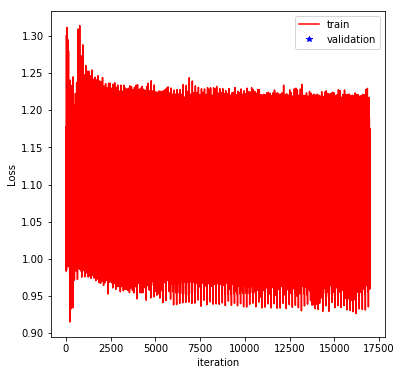

In [37]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % interation_compute_val == 50], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

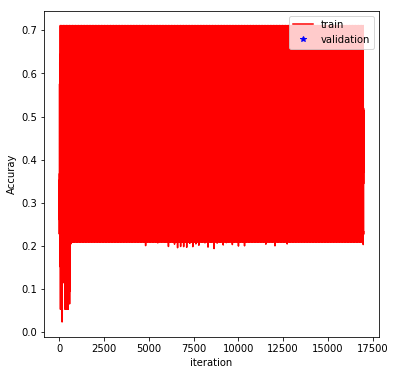

In [38]:

# Plot Accuracies# Plot A 
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % interation_compute_val == 50], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Evaluate on test set

In [39]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    print(y_vld.shape)
    for x_t, y_t in get_batches(X_vld, y_vld, batch_size):        
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        print(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints\har-lstm.ckpt
(70626, 3)
0.478516
0.634766
0.390137
0.580078
0.434082
0.516113
0.537109
0.512207
0.516602
0.393555
0.513672
0.544922
0.507813
0.47998
0.382324
0.230469
0.0126953
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
Test accuracy: 0.225442


In [40]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  10],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a.max(axis=1) >= 10])


[[ 0  1  2  0  4  5  6  7  8 10]
 [ 0 11  0 13  0 15  0 17 18  0]]


In [41]:

a = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0]])
print (a[a[:,2]!=0])

[[0 1 2 0 4 5 6 7 8 9]]


In [42]:
print(ytest[:]!=0)
Xtest = np.array([[ 0,  1,  2,  0,  4,  5,  6,  7,  8,  9],
              [ 0, 11,  0, 13,  0, 15,  0, 17, 18,  0],
             [ 0, 11,  0, 13,  0, 15,  0, 11, 1,  1]])
ytest = np.array([ 0,  1,  1])
Xtest = Xtest[ytest[:]!=0,:]
ytest = ytest[ytest[:]!=0]
print(Xtest)
print(ytest)

NameError: name 'ytest' is not defined